In [ ]:
!pip install -Uqq fastai

In [1]:
import urllib.parse
from fastcore.all import *
import json

def query_lexica(search_term):
    term_encoded = urllib.parse.quote_plus(search_term)
    full_query = "https://lexica.art/api/v1/search?q={0}".format(term_encoded)
    images_json = urlread(full_query)
    if not images_json:
        return None
    images = json.loads(images_json)
    return images['images']

query_lexica('white shark')[0]

{'id': '01c85883-c850-4520-addf-961838e01314',
 'gallery': 'https://lexica.art?q=01c85883-c850-4520-addf-961838e01314',
 'src': 'https://lexica-serve-encoded-images.sharif.workers.dev/md/01c85883-c850-4520-addf-961838e01314',
 'srcSmall': 'https://lexica-serve-encoded-images.sharif.workers.dev/sm/01c85883-c850-4520-addf-961838e01314',
 'prompt': 'giant shark smiling, trending on artstation, dark atmospheric lighting rear view sacred geometry, 8 k ',
 'width': 512,
 'height': 512,
 'seed': '3132928249',
 'grid': False,
 'model': 'stable-diffusion',
 'promptid': 'cab093b0-0bda-4c13-89ac-bd91edf78385'}

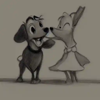

In [9]:
from fastdownload import *
import time
from pathlib import Path

def save_images_from_lexica(search_term, folder=Path("stable-diffusion"), max_num_images=0, image_paths=[]):
    for image_info in query_lexica(search_term):
        if max_num_images and len(image_paths) == max_num_images:
            break
        file = folder / "{0}.png".format(image_info["id"])
        download_url(image_info["srcSmall"], file, show_progress=False)
        image_paths.append(file)
        time.sleep(0.2)
    if max_num_images and len(image_paths) < max_num_images:
        image_paths = save_images_from_lexica(image_info['id'], folder, max_num_images, image_paths)
    return image_paths

from fastai.vision.all import *
paths = save_images_from_lexica("best friend", max_num_images=2)
Image.open(paths[0]).to_thumb(100, 100)

In [10]:
images_folder = Path('dali_or_bosch')
dalis = save_images_from_lexica('painting by Salvador Dali', images_folder / 'dali', max_num_images=300)
bosches = save_images_from_lexica('painting by Hyeronymous Bosch', images_folder / 'bosch', max_num_images=300)
[len(dalis), len(bosches)]


[300, 300]

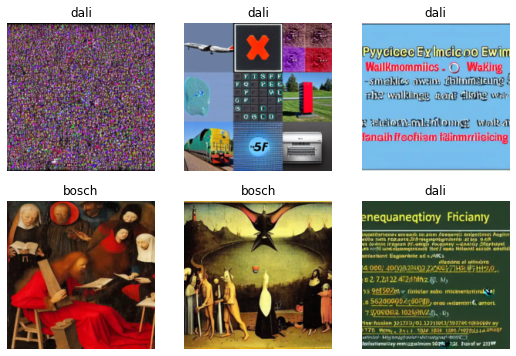

In [15]:
path = Path('dali_or_bosch')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.226393,1.728564,0.540000,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.393424,0.735650,0.320000,00:37
1,0.340225,0.465692,0.140000,00:36
2,0.251345,0.320664,0.140000,00:36
3,0.201540,0.073951,0.040000,00:37
4,0.200018,0.035391,0.000000,00:36


In [19]:
orig_bosch = 'https://www.wga.hu/art/b/bosch/3garden/wings/24right.jpg'
download_url(orig_bosch, 'bosch.jpg', show_progress=False)

orig_dali = 'https://upload.wikimedia.org/wikipedia/en/9/90/DaliGreatMasturbator.jpg'
download_url(orig_dali, 'dali.jpg', show_progress=False)

dali_or_bosch,_,probs = learn.predict(PILImage.create('bosch.jpg'))
print(f"I think Bosch is a: {dali_or_bosch} with a probability of {probs[0]:.4f}")

dali_or_bosch,_,probs = learn.predict(PILImage.create('dali.jpg'))
print(f"I think Dali is a: {dali_or_bosch} with a probability of {probs[0]:.4f}")


I think Bosch is a: bosch with a probability of 1.0000


I think Dali is a: bosch with a probability of 0.5626
